## Считываем данные. Сегодня без pandas

In [32]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


### Выделим целевую переменную
#### Обратим внимание что переменая осталась в массиве независимых переменных

In [33]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

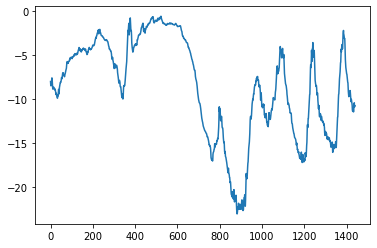

In [11]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

#plt.plot(range(1440), temperature[:1440]) # первые 10 дней

In [13]:
raw_data.shape, temperature.shape

((420451, 14), (420451,))

In [34]:
# Определим количество обучающих, тестовых и проверочных примеров
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Подготовим данные

#### Нормализуем

In [35]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

#### Знакомство с новым генератором


In [90]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(50)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=5,
    #sampling_rate=2,
    batch_size=3,
)



In [86]:
int_sequence[3:]

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [91]:
for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 2, 4, 6, 8] 10
[1, 3, 5, 7, 9] 11
[2, 4, 6, 8, 10] 12
[3, 5, 7, 9, 11] 13
[4, 6, 8, 10, 12] 14
[5, 7, 9, 11, 13] 15
[6, 8, 10, 12, 14] 16
[7, 9, 11, 13, 15] 17
[8, 10, 12, 14, 16] 18
[9, 11, 13, 15, 17] 19
[10, 12, 14, 16, 18] 20
[11, 13, 15, 17, 19] 21
[12, 14, 16, 18, 20] 22
[13, 15, 17, 19, 21] 23
[14, 16, 18, 20, 22] 24
[15, 17, 19, 21, 23] 25
[16, 18, 20, 22, 24] 26
[17, 19, 21, 23, 25] 27
[18, 20, 22, 24, 26] 28
[19, 21, 23, 25, 27] 29
[20, 22, 24, 26, 28] 30
[21, 23, 25, 27, 29] 31
[22, 24, 26, 28, 30] 32
[23, 25, 27, 29, 31] 33
[24, 26, 28, 30, 32] 34
[25, 27, 29, 31, 33] 35
[26, 28, 30, 32, 34] 36
[27, 29, 31, 33, 35] 37
[28, 30, 32, 34, 36] 38
[29, 31, 33, 35, 37] 39
[30, 32, 34, 36, 38] 40


In [93]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate *(sequence_length + 24 - 1)
batch_size = 256


In [94]:
6*24

144

In [95]:

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [96]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [69]:
# Базовое решение прогноз

In [97]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [16]:
raw_data.shape[-1]

14

In [82]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)

# Ответы на вопросы из лекции вписать сюда

Epoch 1/10
818/818 [==============================] - 11s 13ms/step - loss: 4.2472 - mae: 1.5069 - val_loss: 1.0243 - val_mae: 0.8153
Epoch 2/10
818/818 [==============================] - 11s 13ms/step - loss: 1.6959 - mae: 1.0338 - val_loss: 1.1126 - val_mae: 0.8641
Epoch 3/10
818/818 [==============================] - 10s 13ms/step - loss: 1.2559 - mae: 0.8854 - val_loss: 1.4998 - val_mae: 1.0239
Epoch 4/10
818/818 [==============================] - 10s 12ms/step - loss: 1.0094 - mae: 0.8039 - val_loss: 0.8538 - val_mae: 0.7623
Epoch 5/10
818/818 [==============================] - 10s 13ms/step - loss: 0.8406 - mae: 0.7253 - val_loss: 0.6369 - val_mae: 0.6392
Epoch 6/10
818/818 [==============================] - 11s 13ms/step - loss: 0.7181 - mae: 0.6772 - val_loss: 0.3345 - val_mae: 0.4587
Epoch 7/10
818/818 [==============================] - 10s 13ms/step - loss: 0.6237 - mae: 0.6312 - val_loss: 0.7900 - val_mae: 0.7415
Epoch 8/10
818/818 [==============================] - 11s 13ms

#### рисовашка

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Одномерная сверточная сеть

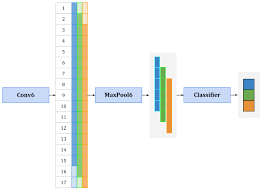

In [83]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)

#
#
#

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
818/818 [==============================] - 24s 29ms/step - loss: 11.4935 - mae: 2.5444 - val_loss: 9.1174 - val_mae: 2.3746
Epoch 2/10
818/818 [==============================] - 24s 29ms/step - loss: 5.8816 - mae: 1.8891 - val_loss: 6.0493 - val_mae: 1.9150
Epoch 3/10
818/818 [==============================] - 24s 29ms/step - loss: 5.1402 - mae: 1.7755 - val_loss: 3.8818 - val_mae: 1.5423
Epoch 4/10
818/818 [==============================] - 23s 28ms/step - loss: 4.7015 - mae: 1.7020 - val_loss: 3.6797 - val_mae: 1.5057
Epoch 5/10
818/818 [==============================] - 24s 29ms/step - loss: 4.3943 - mae: 1.6480 - val_loss: 3.8870 - val_mae: 1.5594
Epoch 6/10
818/818 [==============================] - 25s 30ms/step - loss: 4.1999 - mae: 1.6122 - val_loss: 3.7205 - val_mae: 1.5224
Epoch 7/10
278/818 [=========>....................] - ETA: 13s - loss: 4.1164 - mae: 1.5953

KeyboardInterrupt: 

In [98]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

x = layers.LSTM(16)(inputs)

# 

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.h5",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 33s 38ms/step - loss: 38.1108 - mae: 4.4847 - val_loss: 11.9668 - val_mae: 2.6332
Epoch 2/10
819/819 [==============================] - 31s 38ms/step - loss: 10.8703 - mae: 2.5705 - val_loss: 10.5640 - val_mae: 2.4617
Epoch 3/10
819/819 [==============================] - 32s 39ms/step - loss: 9.9704 - mae: 2.4659 - val_loss: 9.8815 - val_mae: 2.4220
Epoch 4/10
819/819 [==============================] - 32s 38ms/step - loss: 9.6983 - mae: 2.4299 - val_loss: 10.2950 - val_mae: 2.4387
Epoch 5/10
819/819 [==============================] - 31s 38ms/step - loss: 9.4587 - mae: 2.3947 - val_loss: 10.1809 - val_mae: 2.4341
Epoch 6/10
819/819 [==============================] - 31s 38ms/step - loss: 9.3021 - mae: 2.3719 - val_loss: 10.0794 - val_mae: 2.4226
Epoch 7/10
819/819 [==============================] - 32s 38ms/step - loss: 9.0146 - mae: 2.3354 - val_loss: 10.3685 - val_mae: 2.4504
Epoch 8/10
819/819 [==============================] - 

### Псевдокод рекуррентной сети by numpy

In [ ]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks